# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check:  https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [3]:
# Import training and validation sets
df = pd.read_csv('bluebook-for-bulldozers/bluebook-for-bulldozers/TrainandValid.csv',
                 low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

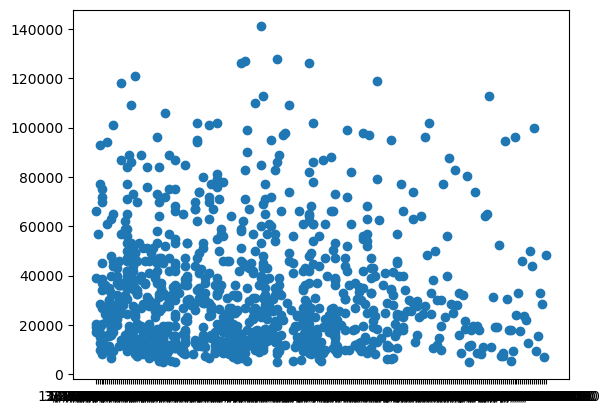

In [7]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

In [8]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

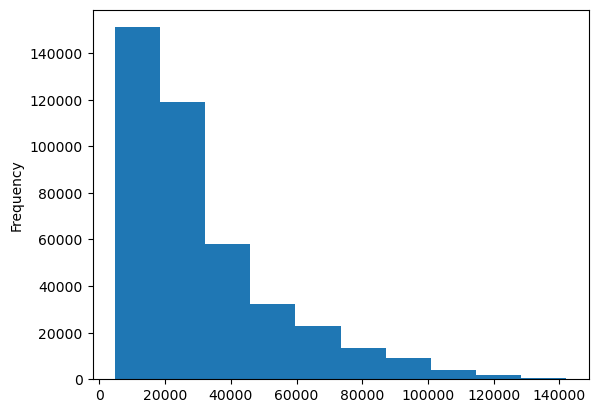

In [9]:
df.SalePrice.plot.hist();

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the 'parse_dates' parameter

In [10]:
# Import data again but this time parse dates
df = pd.read_csv('bluebook-for-bulldozers/bluebook-for-bulldozers/TrainAndValid.csv',
                 low_memory=False,
                 parse_dates=['saledate'])

In [11]:
df.saledate.dtype

dtype('<M8[ns]')

In [12]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

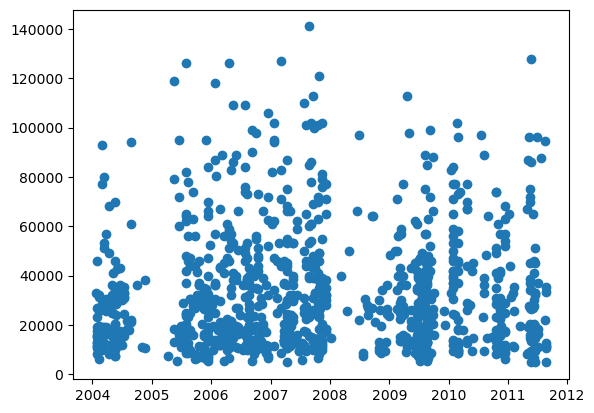

In [13]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

In [14]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [16]:
# Sort DataFrame in date order
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df.saledate.head(1000)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
            ...    
54344    1989-03-16
143206   1989-03-16
93144    1989-03-16
86917    1989-03-16
115938   1989-03-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data

In [17]:
# Make a copy
df_tmp = df.copy()

In [18]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


### Add datetime parameters for 'saledate' column

In [19]:
df_tmp['SaleYear'] = df_tmp.saledate.dt.year
df_tmp['SaleMonth'] = df_tmp.saledate.dt.month
df_tmp['SaleDay'] = df_tmp.saledate.dt.day
df_tmp['SaleDayofWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['SaleDayofYear'] = df_tmp.saledate.dt.dayofyear

In [20]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [21]:
# Now we've enriched our DataFrame woth date time features, we can remove sale date
df_tmp.drop('saledate', axis=1, inplace=True)

In [22]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [28]:
# Let's build a machine learning model
from sklearn.ensemble import RandomForestRegressor

# Specifying -1 so it uses all the computer power and memory
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

model.fit(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

ValueError: could not convert string to float: 'Low'

In [23]:
df_tmp['UsageBand'].dtype

dtype('O')

In [24]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert strings to categories

One way we can turn all of our data into numbers is by converting them into pandas categories.

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality

In [25]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [26]:
pd.api.types.is_string_dtype(df_tmp['UsageBand'])

True

In [27]:
# Find the columns which contains strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [28]:
# This will turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [29]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [30]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [31]:
df_tmp.Stick.cat.codes
# -1 is for NaN values

205615   -1
274835   -1
141296   -1
212552   -1
62755    -1
         ..
410879   -1
412476   -1
411927   -1
407124   -1
409203   -1
Length: 412698, dtype: int8

Thanks to pandas Categories we now have a way to access all of our data in the form of numbers

But we still have a bunch if missing data...

In [32]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data


In [33]:
# Export current tmp dataframe
df_tmp.to_csv('bluebook-for-bulldozers/bluebook-for-bulldozers/train_tmp.csv',
              index=False)

In [34]:
# Import preprocessed data
df_tmp = pd.read_csv('bluebook-for-bulldozers/bluebook-for-bulldozers/train_tmp.csv',
                low_memory=False)

df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [35]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Fill missing values

#### Fill numeric missing values first

In [36]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
SaleYear
SaleMonth
SaleDay
SaleDayofWeek
SaleDayofYear


In [37]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [38]:
# Fill numeric rows with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data is missing or not
            df_tmp[label+'_is_missing'] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [39]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [40]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [41]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorical variables into numbers

In [42]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
            print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [43]:
# Turn categorical variables into number and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binaryy column to indicate whether sample had missing values
        df_tmp[label+'_is_missing'] = pd.isnull(content)
        # Turn categories into numbers and add +1
        # because if null in categorical pd makes it -1 so to be 0
        df_tmp[label] = pd.Categorical(content).codes + 1

In [44]:
pd.Categorical(df_tmp['state']).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [45]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [46]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [47]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model

In [48]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# Fit the model
model.fit(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

NameError: name 'RandomForestRegressor' is not defined

In [56]:
# Score the model
model.score(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

0.9875468079970562

**Question:** Why doesn't the above metric holds water? (why isn't the metric reliable?)

### Splitting data into train/validation sets

In [49]:
df_tmp.SaleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: SaleYear, dtype: int64

In [50]:
# Split data into training and validation
df_val = df_tmp[df_tmp.SaleYear == 2012]
df_train = df_tmp[df_tmp.SaleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [51]:
# Split data into x and y
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val['SalePrice']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

In [52]:
# Create evaluation function (the competition usd RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    '''
    Calculates root mean squared log error between predictions and true labels.
    '''
    
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model n few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
              'Valid MAE': mean_absolute_error(y_valid, val_preds),
              'Training RMSLE': rmsle(y_train, train_preds),
              'Valid RMSLE': rmsle(y_valid, val_preds),
              'Training R^2': r2_score(y_train, train_preds),
              'Valid R^2': r2_score(y_valid, val_preds)}
    return scores


## Testing our model on a subset (to tune the hyperparameters)

In [53]:
## This takes far too long ... for experimenting

# %%time
# model = RandomForestRegressor(n_jobs=-1,
#                              random_state=42)

# model.fit(X_train, y_train)

In [54]:
len(X_train)

401125

In [ ]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [ ]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

In [ ]:
show_scores(model)

### Hyperparameter tuning with RandomizedSearchCV

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rs_grid = {'n_estimators': np.arange(10,100,10),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2),
           'max_features': [0.5, 1, 'sqrt', 'auto']}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rs_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

In [ ]:
# Find the best model hyperparamters
rs_model.best_params_

In [ ]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

### Train a model with the best hyperparameters

**Note:** These were found after 1000 iterations of RandomizedSearchCV

In [ ]:
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

In [ ]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

## Make predictions on test data

In [55]:
# Import the test data
df_test = pd.read_csv('bluebook-for-bulldozers/bluebook-for-bulldozers/test.csv',
                     low_memory=False,
                     parse_dates=['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [56]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(df_test)

NameError: name 'ideal_model' is not defined

In [57]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [58]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [59]:
def preprocessed_data(df):
    '''
    Performs transformations in df and returns transformed df
    '''
    df["SaleYear"] = df.saledate.dt.year
    df["SaleMonth"] = df.saledate.dt.month
    df["SaleDay"] = df.saledate.dt.day
    df["SaleDayofWeek"] = df.saledate.dt.dayofweek
    df["SaleDayofYear"] = df.saledate.dt.dayofyear

    df.drop("saledate", axis=1, inplace=True)

    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())

        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+'_is_missing'] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [60]:
# Process the test data
df_test = preprocessed_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [66]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

NameError: name 'ideal_model' is not defined

In [61]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [62]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test['auctioneerID_is_missing'] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [63]:
# To see if the columns are on the correct order as the training dataset
print(X_train.columns == df_test.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


In [64]:
# Make test dataset columns to have the same order as training one
df_test = df_test[X_train.columns]

In [75]:
print(X_train.columns == df_test.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [72]:
# Make predictions on test data
test_preds = ideal_model.predict(df_test)

NameError: name 'ideal_model' is not defined

In [73]:
len(test_preds)

NameError: name 'test_preds' is not defined

We've made some predictions but they're not in the same format Kaggle is asking for: https://www.kaggle.com/competitions/bluebook-bulldozer-remix/overview/evaluation

In [65]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalePrice'] = test_preds
df_preds

NameError: name 'test_preds' is not defined

In [ ]:
# Export prediction data
df_preds.to_csv('bluebook-for-bulldozers/bluebook-for-bulldozers/test_predictions.csv',
                index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were of most importance when it comes to predicting the target variable (SalePrice).

In [66]:
# Find feature importance of our best model
ideal_model.feature_importances_

NameError: name 'ideal_model' is not defined

In [ ]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
          .sort_values('feature_importances', ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importance')
    ax.invert_yaxis()

In [ ]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [ ]:
df['Enclosure'].value_counts()

**Question to finish:** Why might knowing the feature importances of a trained machine learning model be helpful?

**Final challenge/extension:** What other machine learning models could you try on our dataset?

**Hint:** https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html check out the regression section of this map, or try to look at something like CatBoost.ai or XGBooost.ai.

### CatBoostRegressor

In [ ]:
# Try CatBoost.ai
# Intsall first
!pip install catboost

In [67]:
# Then import
import catboost

In [ ]:
# Create evaluation function (the competition usd RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    '''
    Calculates root mean squared log error between predictions and true labels.
    '''
    
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model n few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
              'Valid MAE': mean_absolute_error(y_valid, val_preds),
              'Training RMSLE': rmsle(y_train, train_preds),
              'Valid RMSLE': rmsle(y_valid, val_preds),
              'Training R^2': r2_score(y_train, train_preds),
              'Valid R^2': r2_score(y_valid, val_preds)}
    return scores


In [85]:
# CatBoostRegressor
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(depth=10,
                              l2_leaf_reg=3,
                              learning_rate=None,
                              random_strength=2,
                              iterations=3000)
model_cat.fit(X_train, y_train)

0:	learn: 22599.7966592	total: 530ms	remaining: 26m 28s
1:	learn: 22168.4339456	total: 906ms	remaining: 22m 37s
2:	learn: 21763.6804888	total: 1.33s	remaining: 22m 8s
3:	learn: 21378.6691665	total: 1.74s	remaining: 21m 42s
4:	learn: 20988.1895083	total: 2s	remaining: 19m 57s
5:	learn: 20623.0910468	total: 2.25s	remaining: 18m 44s
6:	learn: 20267.0060533	total: 2.53s	remaining: 18m 2s
7:	learn: 19926.8824174	total: 2.83s	remaining: 17m 37s
8:	learn: 19590.3741755	total: 3.1s	remaining: 17m 11s
9:	learn: 19274.5004660	total: 3.42s	remaining: 17m 3s
10:	learn: 18967.4100183	total: 3.82s	remaining: 17m 19s
11:	learn: 18670.0032964	total: 4.16s	remaining: 17m 15s
12:	learn: 18377.2238289	total: 4.49s	remaining: 17m 12s
13:	learn: 18121.9241882	total: 4.93s	remaining: 17m 30s
14:	learn: 17863.5364106	total: 5.27s	remaining: 17m 28s
15:	learn: 17603.2429651	total: 5.55s	remaining: 17m 14s
16:	learn: 17351.1726362	total: 5.85s	remaining: 17m 7s
17:	learn: 17110.9475026	total: 6.11s	remaining: 

145:	learn: 9525.1350876	total: 41.4s	remaining: 13m 28s
146:	learn: 9516.1682446	total: 41.6s	remaining: 13m 26s
147:	learn: 9499.4134396	total: 41.8s	remaining: 13m 25s
148:	learn: 9482.9988938	total: 42.1s	remaining: 13m 24s
149:	learn: 9464.2634414	total: 42.4s	remaining: 13m 25s
150:	learn: 9450.6154936	total: 42.7s	remaining: 13m 25s
151:	learn: 9437.6361996	total: 43s	remaining: 13m 25s
152:	learn: 9426.1342842	total: 43.3s	remaining: 13m 25s
153:	learn: 9411.4983526	total: 43.6s	remaining: 13m 25s
154:	learn: 9399.5703635	total: 43.8s	remaining: 13m 24s
155:	learn: 9384.8538139	total: 44s	remaining: 13m 22s
156:	learn: 9373.3778531	total: 44.3s	remaining: 13m 21s
157:	learn: 9360.3346628	total: 44.5s	remaining: 13m 20s
158:	learn: 9349.6658572	total: 44.8s	remaining: 13m 19s
159:	learn: 9340.8222693	total: 45s	remaining: 13m 18s
160:	learn: 9333.7019775	total: 45.2s	remaining: 13m 17s
161:	learn: 9322.1003776	total: 45.4s	remaining: 13m 15s
162:	learn: 9310.6150277	total: 45.6s

291:	learn: 8396.6272557	total: 1m 16s	remaining: 11m 45s
292:	learn: 8392.9645731	total: 1m 16s	remaining: 11m 44s
293:	learn: 8388.7800170	total: 1m 16s	remaining: 11m 44s
294:	learn: 8384.4493519	total: 1m 16s	remaining: 11m 43s
295:	learn: 8379.8617568	total: 1m 17s	remaining: 11m 43s
296:	learn: 8376.0711297	total: 1m 17s	remaining: 11m 43s
297:	learn: 8371.2124381	total: 1m 17s	remaining: 11m 42s
298:	learn: 8367.4710815	total: 1m 17s	remaining: 11m 41s
299:	learn: 8362.6086120	total: 1m 17s	remaining: 11m 41s
300:	learn: 8360.4192351	total: 1m 18s	remaining: 11m 43s
301:	learn: 8355.8679486	total: 1m 18s	remaining: 11m 42s
302:	learn: 8351.5996294	total: 1m 18s	remaining: 11m 42s
303:	learn: 8347.4608416	total: 1m 19s	remaining: 11m 42s
304:	learn: 8344.0273160	total: 1m 19s	remaining: 11m 42s
305:	learn: 8339.3652961	total: 1m 19s	remaining: 11m 43s
306:	learn: 8335.1682585	total: 1m 20s	remaining: 11m 44s
307:	learn: 8331.8398605	total: 1m 20s	remaining: 11m 45s
308:	learn: 83

433:	learn: 7881.7564603	total: 1m 50s	remaining: 10m 56s
434:	learn: 7877.7086294	total: 1m 51s	remaining: 10m 55s
435:	learn: 7874.9658092	total: 1m 51s	remaining: 10m 54s
436:	learn: 7872.6777382	total: 1m 51s	remaining: 10m 54s
437:	learn: 7868.5643752	total: 1m 51s	remaining: 10m 53s
438:	learn: 7865.2039457	total: 1m 52s	remaining: 10m 53s
439:	learn: 7862.7399690	total: 1m 52s	remaining: 10m 53s
440:	learn: 7859.4089689	total: 1m 52s	remaining: 10m 52s
441:	learn: 7855.4835514	total: 1m 52s	remaining: 10m 52s
442:	learn: 7852.6086124	total: 1m 53s	remaining: 10m 52s
443:	learn: 7848.3568071	total: 1m 53s	remaining: 10m 52s
444:	learn: 7844.6768819	total: 1m 53s	remaining: 10m 51s
445:	learn: 7842.0290501	total: 1m 53s	remaining: 10m 50s
446:	learn: 7839.7019839	total: 1m 53s	remaining: 10m 50s
447:	learn: 7836.4982373	total: 1m 54s	remaining: 10m 50s
448:	learn: 7833.3891946	total: 1m 54s	remaining: 10m 49s
449:	learn: 7830.8775156	total: 1m 54s	remaining: 10m 49s
450:	learn: 78

576:	learn: 7499.3953162	total: 2m 23s	remaining: 10m 1s
577:	learn: 7496.9640091	total: 2m 23s	remaining: 10m 1s
578:	learn: 7494.7708516	total: 2m 23s	remaining: 10m 1s
579:	learn: 7492.3830115	total: 2m 23s	remaining: 10m
580:	learn: 7490.2996302	total: 2m 24s	remaining: 10m
581:	learn: 7488.8606243	total: 2m 24s	remaining: 9m 59s
582:	learn: 7487.6330937	total: 2m 24s	remaining: 9m 59s
583:	learn: 7484.9810061	total: 2m 24s	remaining: 9m 59s
584:	learn: 7482.6996233	total: 2m 25s	remaining: 9m 58s
585:	learn: 7480.3484750	total: 2m 25s	remaining: 9m 58s
586:	learn: 7477.8395619	total: 2m 25s	remaining: 9m 58s
587:	learn: 7475.6034841	total: 2m 25s	remaining: 9m 57s
588:	learn: 7473.1444897	total: 2m 25s	remaining: 9m 57s
589:	learn: 7470.7605759	total: 2m 26s	remaining: 9m 57s
590:	learn: 7468.4162532	total: 2m 26s	remaining: 9m 56s
591:	learn: 7466.3326197	total: 2m 26s	remaining: 9m 56s
592:	learn: 7463.7595174	total: 2m 26s	remaining: 9m 56s
593:	learn: 7461.5210088	total: 2m 27

720:	learn: 7241.6939803	total: 3m	remaining: 9m 31s
721:	learn: 7240.0362851	total: 3m 1s	remaining: 9m 31s
722:	learn: 7238.0119391	total: 3m 1s	remaining: 9m 31s
723:	learn: 7236.4455081	total: 3m 1s	remaining: 9m 30s
724:	learn: 7234.3508585	total: 3m 1s	remaining: 9m 30s
725:	learn: 7232.8029830	total: 3m 2s	remaining: 9m 30s
726:	learn: 7231.6672773	total: 3m 2s	remaining: 9m 30s
727:	learn: 7229.6710261	total: 3m 2s	remaining: 9m 30s
728:	learn: 7228.1846752	total: 3m 3s	remaining: 9m 30s
729:	learn: 7226.7627934	total: 3m 3s	remaining: 9m 29s
730:	learn: 7225.0031736	total: 3m 3s	remaining: 9m 29s
731:	learn: 7223.7023377	total: 3m 3s	remaining: 9m 29s
732:	learn: 7222.4353324	total: 3m 4s	remaining: 9m 29s
733:	learn: 7221.0361907	total: 3m 4s	remaining: 9m 28s
734:	learn: 7219.4890780	total: 3m 4s	remaining: 9m 28s
735:	learn: 7217.9391877	total: 3m 4s	remaining: 9m 28s
736:	learn: 7216.9388692	total: 3m 4s	remaining: 9m 27s
737:	learn: 7215.3648700	total: 3m 5s	remaining: 9m

866:	learn: 7038.0945178	total: 3m 36s	remaining: 8m 53s
867:	learn: 7036.6596329	total: 3m 37s	remaining: 8m 53s
868:	learn: 7035.7941274	total: 3m 37s	remaining: 8m 52s
869:	learn: 7034.9201388	total: 3m 37s	remaining: 8m 52s
870:	learn: 7033.7049930	total: 3m 37s	remaining: 8m 52s
871:	learn: 7032.4644366	total: 3m 38s	remaining: 8m 52s
872:	learn: 7031.2718962	total: 3m 38s	remaining: 8m 52s
873:	learn: 7030.2789266	total: 3m 38s	remaining: 8m 52s
874:	learn: 7028.9053244	total: 3m 39s	remaining: 8m 52s
875:	learn: 7027.7387163	total: 3m 39s	remaining: 8m 51s
876:	learn: 7026.5630496	total: 3m 39s	remaining: 8m 51s
877:	learn: 7025.3017741	total: 3m 39s	remaining: 8m 51s
878:	learn: 7024.4139418	total: 3m 40s	remaining: 8m 50s
879:	learn: 7023.2360253	total: 3m 40s	remaining: 8m 50s
880:	learn: 7021.7246704	total: 3m 40s	remaining: 8m 50s
881:	learn: 7020.4262839	total: 3m 40s	remaining: 8m 49s
882:	learn: 7019.4714988	total: 3m 40s	remaining: 8m 49s
883:	learn: 7017.9845440	total:

1011:	learn: 6873.1712388	total: 4m 10s	remaining: 8m 11s
1012:	learn: 6872.2854305	total: 4m 10s	remaining: 8m 11s
1013:	learn: 6871.0485751	total: 4m 10s	remaining: 8m 11s
1014:	learn: 6870.0845924	total: 4m 11s	remaining: 8m 10s
1015:	learn: 6869.4057614	total: 4m 11s	remaining: 8m 10s
1016:	learn: 6868.1804721	total: 4m 11s	remaining: 8m 10s
1017:	learn: 6867.5729747	total: 4m 11s	remaining: 8m 10s
1018:	learn: 6866.6177323	total: 4m 11s	remaining: 8m 9s
1019:	learn: 6865.8689153	total: 4m 12s	remaining: 8m 9s
1020:	learn: 6864.9824749	total: 4m 12s	remaining: 8m 8s
1021:	learn: 6864.1923688	total: 4m 12s	remaining: 8m 8s
1022:	learn: 6863.4140125	total: 4m 12s	remaining: 8m 8s
1023:	learn: 6862.3616315	total: 4m 12s	remaining: 8m 7s
1024:	learn: 6861.2211738	total: 4m 13s	remaining: 8m 7s
1025:	learn: 6860.1722026	total: 4m 13s	remaining: 8m 7s
1026:	learn: 6859.3607467	total: 4m 13s	remaining: 8m 7s
1027:	learn: 6858.2790617	total: 4m 13s	remaining: 8m 6s
1028:	learn: 6857.241665

1153:	learn: 6745.2296476	total: 4m 42s	remaining: 7m 31s
1154:	learn: 6744.4932128	total: 4m 42s	remaining: 7m 31s
1155:	learn: 6743.2204409	total: 4m 43s	remaining: 7m 31s
1156:	learn: 6742.6342916	total: 4m 43s	remaining: 7m 31s
1157:	learn: 6741.8203809	total: 4m 43s	remaining: 7m 31s
1158:	learn: 6740.6807752	total: 4m 43s	remaining: 7m 30s
1159:	learn: 6739.8502733	total: 4m 44s	remaining: 7m 30s
1160:	learn: 6738.9111131	total: 4m 44s	remaining: 7m 30s
1161:	learn: 6738.0138316	total: 4m 44s	remaining: 7m 30s
1162:	learn: 6737.0843183	total: 4m 44s	remaining: 7m 30s
1163:	learn: 6736.4333429	total: 4m 45s	remaining: 7m 29s
1164:	learn: 6735.8958983	total: 4m 45s	remaining: 7m 29s
1165:	learn: 6735.1354953	total: 4m 45s	remaining: 7m 29s
1166:	learn: 6734.5028886	total: 4m 46s	remaining: 7m 29s
1167:	learn: 6733.6748591	total: 4m 46s	remaining: 7m 29s
1168:	learn: 6732.9457068	total: 4m 47s	remaining: 7m 29s
1169:	learn: 6732.3259416	total: 4m 47s	remaining: 7m 29s
1170:	learn: 6

1296:	learn: 6627.7756968	total: 5m 25s	remaining: 7m 7s
1297:	learn: 6627.0488828	total: 5m 26s	remaining: 7m 7s
1298:	learn: 6626.3173903	total: 5m 26s	remaining: 7m 7s
1299:	learn: 6625.3883379	total: 5m 26s	remaining: 7m 7s
1300:	learn: 6624.5098066	total: 5m 26s	remaining: 7m 6s
1301:	learn: 6623.8922286	total: 5m 27s	remaining: 7m 6s
1302:	learn: 6623.0731601	total: 5m 27s	remaining: 7m 6s
1303:	learn: 6622.1058447	total: 5m 27s	remaining: 7m 6s
1304:	learn: 6621.4376607	total: 5m 28s	remaining: 7m 6s
1305:	learn: 6620.4469716	total: 5m 28s	remaining: 7m 6s
1306:	learn: 6619.6057765	total: 5m 28s	remaining: 7m 5s
1307:	learn: 6618.8476264	total: 5m 29s	remaining: 7m 5s
1308:	learn: 6617.9546871	total: 5m 29s	remaining: 7m 5s
1309:	learn: 6617.1442870	total: 5m 29s	remaining: 7m 5s
1310:	learn: 6616.3611163	total: 5m 30s	remaining: 7m 5s
1311:	learn: 6615.9411745	total: 5m 30s	remaining: 7m 5s
1312:	learn: 6614.8287008	total: 5m 30s	remaining: 7m 4s
1313:	learn: 6613.6878487	total

1440:	learn: 6520.9487275	total: 6m 9s	remaining: 6m 39s
1441:	learn: 6520.1700990	total: 6m 9s	remaining: 6m 38s
1442:	learn: 6519.4738104	total: 6m 9s	remaining: 6m 38s
1443:	learn: 6518.9762015	total: 6m 9s	remaining: 6m 38s
1444:	learn: 6518.4335168	total: 6m 10s	remaining: 6m 38s
1445:	learn: 6517.2393710	total: 6m 10s	remaining: 6m 38s
1446:	learn: 6516.6298808	total: 6m 10s	remaining: 6m 37s
1447:	learn: 6516.0353584	total: 6m 10s	remaining: 6m 37s
1448:	learn: 6515.1275824	total: 6m 11s	remaining: 6m 37s
1449:	learn: 6514.4451387	total: 6m 11s	remaining: 6m 36s
1450:	learn: 6514.0095712	total: 6m 11s	remaining: 6m 36s
1451:	learn: 6513.2629034	total: 6m 11s	remaining: 6m 36s
1452:	learn: 6512.5725543	total: 6m 12s	remaining: 6m 36s
1453:	learn: 6511.7875263	total: 6m 12s	remaining: 6m 36s
1454:	learn: 6511.0862008	total: 6m 12s	remaining: 6m 35s
1455:	learn: 6510.4486886	total: 6m 13s	remaining: 6m 35s
1456:	learn: 6509.7965122	total: 6m 13s	remaining: 6m 35s
1457:	learn: 6509.

1582:	learn: 6426.2059235	total: 6m 50s	remaining: 6m 7s
1583:	learn: 6425.6576651	total: 6m 51s	remaining: 6m 7s
1584:	learn: 6424.8630386	total: 6m 51s	remaining: 6m 7s
1585:	learn: 6424.2395631	total: 6m 51s	remaining: 6m 7s
1586:	learn: 6423.7025138	total: 6m 52s	remaining: 6m 7s
1587:	learn: 6423.3912776	total: 6m 52s	remaining: 6m 6s
1588:	learn: 6422.4724754	total: 6m 52s	remaining: 6m 6s
1589:	learn: 6421.7931639	total: 6m 53s	remaining: 6m 6s
1590:	learn: 6421.1040730	total: 6m 53s	remaining: 6m 6s
1591:	learn: 6420.4822988	total: 6m 53s	remaining: 6m 6s
1592:	learn: 6419.4691615	total: 6m 54s	remaining: 6m 5s
1593:	learn: 6418.9160018	total: 6m 54s	remaining: 6m 5s
1594:	learn: 6417.9601470	total: 6m 54s	remaining: 6m 5s
1595:	learn: 6417.0823639	total: 6m 55s	remaining: 6m 5s
1596:	learn: 6416.4244972	total: 6m 55s	remaining: 6m 4s
1597:	learn: 6416.0300857	total: 6m 55s	remaining: 6m 4s
1598:	learn: 6415.2516534	total: 6m 55s	remaining: 6m 4s
1599:	learn: 6414.6500432	total

1725:	learn: 6338.0218678	total: 7m 31s	remaining: 5m 33s
1726:	learn: 6337.4601777	total: 7m 31s	remaining: 5m 33s
1727:	learn: 6336.8549657	total: 7m 32s	remaining: 5m 32s
1728:	learn: 6336.3545872	total: 7m 32s	remaining: 5m 32s
1729:	learn: 6335.4460735	total: 7m 32s	remaining: 5m 32s
1730:	learn: 6334.5858682	total: 7m 33s	remaining: 5m 32s
1731:	learn: 6334.0738556	total: 7m 33s	remaining: 5m 31s
1732:	learn: 6333.4840746	total: 7m 33s	remaining: 5m 31s
1733:	learn: 6333.1394361	total: 7m 33s	remaining: 5m 31s
1734:	learn: 6332.1883782	total: 7m 34s	remaining: 5m 31s
1735:	learn: 6331.7356949	total: 7m 34s	remaining: 5m 30s
1736:	learn: 6330.8884754	total: 7m 34s	remaining: 5m 30s
1737:	learn: 6330.5541207	total: 7m 34s	remaining: 5m 30s
1738:	learn: 6330.0340841	total: 7m 35s	remaining: 5m 30s
1739:	learn: 6329.2775080	total: 7m 35s	remaining: 5m 29s
1740:	learn: 6328.4622156	total: 7m 35s	remaining: 5m 29s
1741:	learn: 6327.5418186	total: 7m 35s	remaining: 5m 29s
1742:	learn: 6

1868:	learn: 6257.8074078	total: 8m 15s	remaining: 4m 59s
1869:	learn: 6256.9207450	total: 8m 15s	remaining: 4m 59s
1870:	learn: 6256.1226681	total: 8m 15s	remaining: 4m 59s
1871:	learn: 6255.4797122	total: 8m 16s	remaining: 4m 58s
1872:	learn: 6254.8473528	total: 8m 16s	remaining: 4m 58s
1873:	learn: 6254.5201701	total: 8m 16s	remaining: 4m 58s
1874:	learn: 6254.2314659	total: 8m 17s	remaining: 4m 58s
1875:	learn: 6253.3992294	total: 8m 17s	remaining: 4m 58s
1876:	learn: 6252.8266680	total: 8m 17s	remaining: 4m 57s
1877:	learn: 6252.2216193	total: 8m 18s	remaining: 4m 57s
1878:	learn: 6251.5910827	total: 8m 18s	remaining: 4m 57s
1879:	learn: 6251.1938416	total: 8m 19s	remaining: 4m 57s
1880:	learn: 6250.5614196	total: 8m 19s	remaining: 4m 57s
1881:	learn: 6250.3159326	total: 8m 19s	remaining: 4m 56s
1882:	learn: 6249.4366516	total: 8m 20s	remaining: 4m 56s
1883:	learn: 6248.8761056	total: 8m 20s	remaining: 4m 56s
1884:	learn: 6248.3215135	total: 8m 20s	remaining: 4m 56s
1885:	learn: 6

2010:	learn: 6179.3096453	total: 8m 57s	remaining: 4m 24s
2011:	learn: 6178.7438459	total: 8m 57s	remaining: 4m 23s
2012:	learn: 6178.0975884	total: 8m 57s	remaining: 4m 23s
2013:	learn: 6177.5104747	total: 8m 57s	remaining: 4m 23s
2014:	learn: 6176.9467225	total: 8m 58s	remaining: 4m 23s
2015:	learn: 6176.5137822	total: 8m 58s	remaining: 4m 22s
2016:	learn: 6176.0515426	total: 8m 58s	remaining: 4m 22s
2017:	learn: 6175.4364173	total: 8m 59s	remaining: 4m 22s
2018:	learn: 6174.9201419	total: 8m 59s	remaining: 4m 22s
2019:	learn: 6174.2622142	total: 8m 59s	remaining: 4m 21s
2020:	learn: 6173.5313608	total: 8m 59s	remaining: 4m 21s
2021:	learn: 6173.0554383	total: 9m	remaining: 4m 21s
2022:	learn: 6172.7390546	total: 9m	remaining: 4m 21s
2023:	learn: 6172.0471306	total: 9m	remaining: 4m 20s
2024:	learn: 6171.3856239	total: 9m 1s	remaining: 4m 20s
2025:	learn: 6170.9239569	total: 9m 1s	remaining: 4m 20s
2026:	learn: 6170.1994015	total: 9m 2s	remaining: 4m 20s
2027:	learn: 6169.5762984	tot

2153:	learn: 6107.0293818	total: 9m 37s	remaining: 3m 46s
2154:	learn: 6106.4453675	total: 9m 37s	remaining: 3m 46s
2155:	learn: 6106.2744450	total: 9m 38s	remaining: 3m 46s
2156:	learn: 6105.9452142	total: 9m 38s	remaining: 3m 46s
2157:	learn: 6105.3136229	total: 9m 38s	remaining: 3m 45s
2158:	learn: 6104.8862968	total: 9m 39s	remaining: 3m 45s
2159:	learn: 6104.3359309	total: 9m 39s	remaining: 3m 45s
2160:	learn: 6103.7922523	total: 9m 39s	remaining: 3m 45s
2161:	learn: 6103.3160853	total: 9m 40s	remaining: 3m 44s
2162:	learn: 6102.6900469	total: 9m 40s	remaining: 3m 44s
2163:	learn: 6102.1602252	total: 9m 40s	remaining: 3m 44s
2164:	learn: 6101.6240217	total: 9m 40s	remaining: 3m 44s
2165:	learn: 6100.9927679	total: 9m 41s	remaining: 3m 43s
2166:	learn: 6100.6019984	total: 9m 41s	remaining: 3m 43s
2167:	learn: 6100.1820922	total: 9m 41s	remaining: 3m 43s
2168:	learn: 6099.4429879	total: 9m 42s	remaining: 3m 43s
2169:	learn: 6098.9576363	total: 9m 42s	remaining: 3m 42s
2170:	learn: 6

2294:	learn: 6040.4818239	total: 10m 18s	remaining: 3m 10s
2295:	learn: 6039.8989205	total: 10m 18s	remaining: 3m 9s
2296:	learn: 6039.2728774	total: 10m 19s	remaining: 3m 9s
2297:	learn: 6038.7965872	total: 10m 19s	remaining: 3m 9s
2298:	learn: 6038.3399742	total: 10m 19s	remaining: 3m 8s
2299:	learn: 6037.6254441	total: 10m 19s	remaining: 3m 8s
2300:	learn: 6037.2653877	total: 10m 20s	remaining: 3m 8s
2301:	learn: 6036.8236809	total: 10m 20s	remaining: 3m 8s
2302:	learn: 6036.3654022	total: 10m 20s	remaining: 3m 7s
2303:	learn: 6035.9481994	total: 10m 21s	remaining: 3m 7s
2304:	learn: 6035.5214094	total: 10m 21s	remaining: 3m 7s
2305:	learn: 6035.1463182	total: 10m 21s	remaining: 3m 7s
2306:	learn: 6034.5060449	total: 10m 21s	remaining: 3m 6s
2307:	learn: 6034.0872168	total: 10m 21s	remaining: 3m 6s
2308:	learn: 6033.3976178	total: 10m 22s	remaining: 3m 6s
2309:	learn: 6032.8028723	total: 10m 22s	remaining: 3m 5s
2310:	learn: 6032.1653069	total: 10m 22s	remaining: 3m 5s
2311:	learn: 

2434:	learn: 5975.5776398	total: 10m 56s	remaining: 2m 32s
2435:	learn: 5975.3222628	total: 10m 57s	remaining: 2m 32s
2436:	learn: 5975.1013808	total: 10m 57s	remaining: 2m 31s
2437:	learn: 5974.3688624	total: 10m 57s	remaining: 2m 31s
2438:	learn: 5973.7326697	total: 10m 57s	remaining: 2m 31s
2439:	learn: 5973.4128475	total: 10m 58s	remaining: 2m 31s
2440:	learn: 5973.1782984	total: 10m 58s	remaining: 2m 30s
2441:	learn: 5972.9904598	total: 10m 58s	remaining: 2m 30s
2442:	learn: 5972.6677801	total: 10m 59s	remaining: 2m 30s
2443:	learn: 5972.3010658	total: 10m 59s	remaining: 2m 30s
2444:	learn: 5971.9044602	total: 10m 59s	remaining: 2m 29s
2445:	learn: 5971.6500836	total: 11m	remaining: 2m 29s
2446:	learn: 5971.2563405	total: 11m	remaining: 2m 29s
2447:	learn: 5970.6508718	total: 11m	remaining: 2m 29s
2448:	learn: 5970.0019250	total: 11m 1s	remaining: 2m 28s
2449:	learn: 5969.5842451	total: 11m 1s	remaining: 2m 28s
2450:	learn: 5969.3358558	total: 11m 1s	remaining: 2m 28s
2451:	learn:

2575:	learn: 5915.0329969	total: 11m 40s	remaining: 1m 55s
2576:	learn: 5914.6086845	total: 11m 40s	remaining: 1m 54s
2577:	learn: 5914.2782359	total: 11m 40s	remaining: 1m 54s
2578:	learn: 5914.1150022	total: 11m 40s	remaining: 1m 54s
2579:	learn: 5913.8837739	total: 11m 40s	remaining: 1m 54s
2580:	learn: 5913.6321088	total: 11m 41s	remaining: 1m 53s
2581:	learn: 5913.2008057	total: 11m 41s	remaining: 1m 53s
2582:	learn: 5912.5747468	total: 11m 41s	remaining: 1m 53s
2583:	learn: 5912.3040606	total: 11m 41s	remaining: 1m 53s
2584:	learn: 5911.8599125	total: 11m 42s	remaining: 1m 52s
2585:	learn: 5911.2632115	total: 11m 42s	remaining: 1m 52s
2586:	learn: 5910.6615237	total: 11m 42s	remaining: 1m 52s
2587:	learn: 5910.1724320	total: 11m 42s	remaining: 1m 51s
2588:	learn: 5909.7832102	total: 11m 43s	remaining: 1m 51s
2589:	learn: 5909.5087848	total: 11m 43s	remaining: 1m 51s
2590:	learn: 5909.0190564	total: 11m 43s	remaining: 1m 51s
2591:	learn: 5908.7187972	total: 11m 43s	remaining: 1m 5

2715:	learn: 5858.7126918	total: 12m 17s	remaining: 1m 17s
2716:	learn: 5858.2990908	total: 12m 17s	remaining: 1m 16s
2717:	learn: 5857.8045781	total: 12m 18s	remaining: 1m 16s
2718:	learn: 5857.3107764	total: 12m 18s	remaining: 1m 16s
2719:	learn: 5857.0253424	total: 12m 18s	remaining: 1m 16s
2720:	learn: 5856.7236491	total: 12m 18s	remaining: 1m 15s
2721:	learn: 5856.4623435	total: 12m 18s	remaining: 1m 15s
2722:	learn: 5856.0238654	total: 12m 19s	remaining: 1m 15s
2723:	learn: 5855.6926722	total: 12m 19s	remaining: 1m 14s
2724:	learn: 5855.1390114	total: 12m 19s	remaining: 1m 14s
2725:	learn: 5854.7795772	total: 12m 19s	remaining: 1m 14s
2726:	learn: 5854.4880954	total: 12m 20s	remaining: 1m 14s
2727:	learn: 5853.9306777	total: 12m 20s	remaining: 1m 13s
2728:	learn: 5853.4875815	total: 12m 20s	remaining: 1m 13s
2729:	learn: 5853.0168249	total: 12m 21s	remaining: 1m 13s
2730:	learn: 5852.5075107	total: 12m 21s	remaining: 1m 13s
2731:	learn: 5852.1463322	total: 12m 21s	remaining: 1m 1

2857:	learn: 5799.1782334	total: 12m 57s	remaining: 38.6s
2858:	learn: 5798.9668591	total: 12m 57s	remaining: 38.3s
2859:	learn: 5798.6150796	total: 12m 57s	remaining: 38.1s
2860:	learn: 5798.1781171	total: 12m 57s	remaining: 37.8s
2861:	learn: 5797.6518147	total: 12m 58s	remaining: 37.5s
2862:	learn: 5797.4743062	total: 12m 58s	remaining: 37.2s
2863:	learn: 5797.0466885	total: 12m 58s	remaining: 37s
2864:	learn: 5796.8205324	total: 12m 58s	remaining: 36.7s
2865:	learn: 5796.4805044	total: 12m 59s	remaining: 36.4s
2866:	learn: 5796.1455350	total: 12m 59s	remaining: 36.2s
2867:	learn: 5795.6556346	total: 12m 59s	remaining: 35.9s
2868:	learn: 5795.2815200	total: 12m 59s	remaining: 35.6s
2869:	learn: 5794.8681737	total: 13m	remaining: 35.3s
2870:	learn: 5794.4782543	total: 13m	remaining: 35.1s
2871:	learn: 5794.0923208	total: 13m	remaining: 34.8s
2872:	learn: 5793.6373222	total: 13m 1s	remaining: 34.5s
2873:	learn: 5793.1630023	total: 13m 1s	remaining: 34.3s
2874:	learn: 5792.7660764	tota

In [ ]:
print(min(model_cat.predict(X_train)))
print(min(model_cat.predict(X_valid)))
# sometimes it finds negative values (if depth is lower than 7)

In [86]:
show_scores(model_cat)
# The best up to now (0.241): depth:10, l2_leaf_reg=4, random_strength=2, iterations=5000, learning_rate=None
# The best up to now (0.2418): depth:10, l2_leaf_reg=1, random_strength=2, iterations=5000, learning_rate=None
# Gives negative: depth:10, l2_leaf_reg=3, random_strength=2, iterations=3000, learning_rate=None
# Gives 0.2441: depth:12, l2_leaf_reg=3, random_strength=2, learning_rate=None, iterations=4000
# The best up to now (0.2418): depth:10, l2_leaf_reg=3, random_strength=2, iterations=4000, learning_rate=None

{'Training MAE': 3792.1342142990716,
 'Valid MAE': 5807.523256570677,
 'Training RMSLE': 0.19074423400744933,
 'Valid RMSLE': 0.24318193242333777,
 'Training R^2': 0.9378230116776675,
 'Valid R^2': 0.8882402204070474}

### GridSearchCV

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'learning_rate': [None],
    'depth': [9, 10, 11],
    'l2_leaf_reg': [0, 1, 4, 2],
    'iterations': [5000],
    'random_strength': [2, 3, 4]
    # Add more hyperparameters to tune as needed
}

# Create the CatBoostRegressor
catboost_model = CatBoostRegressor()

# Create the GridSearchCV instance
grid_search = GridSearchCV(catboost_model, param_grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV to perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_catboost_model = grid_search.best_estimator_
best_params = grid_search.best_params_


In [80]:
%%time
from sklearn.model_selection import RandomizedSearchCV
# hyperparameter tuning, RandomizedSearchCV


rs_cat_grid = {'depth':list(range(9,11)),
               'l2_leaf_reg':list(range(3,5)),
               'random_strength':list(range(2,4)),
               'iterations':[4000, 5000]}

rs_cat_model = RandomizedSearchCV(CatBoostRegressor(),
                                  rs_cat_grid,
                                  n_iter=5,
                                  cv=2,
                                  scoring='neg_mean_squared_error',
                                  verbose=True,
                                  n_jobs=-1)

rs_cat_model.fit(X_train,y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
0:	learn: 22618.1808016	total: 153ms	remaining: 10m 12s
1:	learn: 22211.4636571	total: 292ms	remaining: 9m 43s
2:	learn: 21816.6652840	total: 447ms	remaining: 9m 55s
3:	learn: 21435.0722902	total: 610ms	remaining: 10m 9s
4:	learn: 21071.7553820	total: 757ms	remaining: 10m 4s
5:	learn: 20722.1455363	total: 898ms	remaining: 9m 57s
6:	learn: 20387.8072852	total: 1.05s	remaining: 9m 58s
7:	learn: 20059.2253181	total: 1.21s	remaining: 10m 2s
8:	learn: 19742.7418521	total: 1.37s	remaining: 10m 7s
9:	learn: 19437.0489820	total: 1.52s	remaining: 10m 8s
10:	learn: 19147.1276730	total: 1.74s	remaining: 10m 31s
11:	learn: 18849.3142676	total: 1.97s	remaining: 10m 53s
12:	learn: 18568.6155325	total: 2.17s	remaining: 11m 6s
13:	learn: 18293.9366703	total: 2.39s	remaining: 11m 19s
14:	learn: 18053.4999808	total: 2.59s	remaining: 11m 29s
15:	learn: 17806.1346879	total: 2.77s	remaining: 11m 29s
16:	learn: 17566.7412506	total: 2.92s	remaining:

145:	learn: 9887.0634749	total: 24.5s	remaining: 10m 47s
146:	learn: 9873.4617082	total: 24.7s	remaining: 10m 47s
147:	learn: 9855.8450663	total: 24.9s	remaining: 10m 46s
148:	learn: 9837.5675135	total: 25s	remaining: 10m 46s
149:	learn: 9828.3972808	total: 25.1s	remaining: 10m 45s
150:	learn: 9813.1662243	total: 25.3s	remaining: 10m 45s
151:	learn: 9800.7221926	total: 25.5s	remaining: 10m 44s
152:	learn: 9792.4808228	total: 25.6s	remaining: 10m 43s
153:	learn: 9779.6210386	total: 25.7s	remaining: 10m 42s
154:	learn: 9769.7298985	total: 25.9s	remaining: 10m 42s
155:	learn: 9757.1311025	total: 26.1s	remaining: 10m 41s
156:	learn: 9741.8947073	total: 26.2s	remaining: 10m 41s
157:	learn: 9729.7336670	total: 26.4s	remaining: 10m 40s
158:	learn: 9717.0613773	total: 26.5s	remaining: 10m 40s
159:	learn: 9708.7218859	total: 26.7s	remaining: 10m 40s
160:	learn: 9692.6527134	total: 26.8s	remaining: 10m 39s
161:	learn: 9681.3100745	total: 27s	remaining: 10m 39s
162:	learn: 9670.5876806	total: 27.

291:	learn: 8684.2753304	total: 47.2s	remaining: 9m 59s
292:	learn: 8678.6934370	total: 47.3s	remaining: 9m 58s
293:	learn: 8675.0001421	total: 47.5s	remaining: 9m 58s
294:	learn: 8670.4035585	total: 47.6s	remaining: 9m 58s
295:	learn: 8664.3501404	total: 47.8s	remaining: 9m 57s
296:	learn: 8660.3695704	total: 47.9s	remaining: 9m 57s
297:	learn: 8654.2338673	total: 48.1s	remaining: 9m 57s
298:	learn: 8647.5207491	total: 48.2s	remaining: 9m 57s
299:	learn: 8642.7575260	total: 48.4s	remaining: 9m 57s
300:	learn: 8637.8735028	total: 48.6s	remaining: 9m 56s
301:	learn: 8632.2979727	total: 48.7s	remaining: 9m 56s
302:	learn: 8629.4200691	total: 48.9s	remaining: 9m 56s
303:	learn: 8622.9354662	total: 49s	remaining: 9m 55s
304:	learn: 8617.5495246	total: 49.2s	remaining: 9m 55s
305:	learn: 8613.7683704	total: 49.3s	remaining: 9m 55s
306:	learn: 8610.0377047	total: 49.5s	remaining: 9m 55s
307:	learn: 8605.1998833	total: 49.7s	remaining: 9m 55s
308:	learn: 8599.2769771	total: 49.8s	remaining: 9

439:	learn: 8126.3790991	total: 1m 10s	remaining: 9m 27s
440:	learn: 8124.3514850	total: 1m 10s	remaining: 9m 27s
441:	learn: 8121.2884121	total: 1m 10s	remaining: 9m 27s
442:	learn: 8118.7472195	total: 1m 10s	remaining: 9m 26s
443:	learn: 8115.9106377	total: 1m 10s	remaining: 9m 26s
444:	learn: 8112.7338543	total: 1m 10s	remaining: 9m 26s
445:	learn: 8109.0685221	total: 1m 11s	remaining: 9m 26s
446:	learn: 8105.6468335	total: 1m 11s	remaining: 9m 26s
447:	learn: 8101.1286167	total: 1m 11s	remaining: 9m 25s
448:	learn: 8099.8276973	total: 1m 11s	remaining: 9m 25s
449:	learn: 8096.8893304	total: 1m 11s	remaining: 9m 25s
450:	learn: 8092.5378165	total: 1m 11s	remaining: 9m 25s
451:	learn: 8088.4917885	total: 1m 12s	remaining: 9m 25s
452:	learn: 8085.1644426	total: 1m 12s	remaining: 9m 24s
453:	learn: 8082.8916913	total: 1m 12s	remaining: 9m 24s
454:	learn: 8079.5204404	total: 1m 12s	remaining: 9m 24s
455:	learn: 8077.3828675	total: 1m 12s	remaining: 9m 24s
456:	learn: 8074.3627835	total:

585:	learn: 7749.7658707	total: 1m 33s	remaining: 9m 4s
586:	learn: 7747.4730487	total: 1m 33s	remaining: 9m 4s
587:	learn: 7745.2036514	total: 1m 33s	remaining: 9m 3s
588:	learn: 7743.4287734	total: 1m 33s	remaining: 9m 3s
589:	learn: 7741.9681858	total: 1m 34s	remaining: 9m 3s
590:	learn: 7740.1995259	total: 1m 34s	remaining: 9m 3s
591:	learn: 7737.3662671	total: 1m 34s	remaining: 9m 3s
592:	learn: 7735.2394367	total: 1m 34s	remaining: 9m 3s
593:	learn: 7733.4173259	total: 1m 34s	remaining: 9m 3s
594:	learn: 7731.4192854	total: 1m 34s	remaining: 9m 3s
595:	learn: 7729.2904216	total: 1m 35s	remaining: 9m 3s
596:	learn: 7727.5259863	total: 1m 35s	remaining: 9m 2s
597:	learn: 7725.5089044	total: 1m 35s	remaining: 9m 2s
598:	learn: 7723.9603005	total: 1m 35s	remaining: 9m 2s
599:	learn: 7721.1315799	total: 1m 35s	remaining: 9m 2s
600:	learn: 7718.7339813	total: 1m 35s	remaining: 9m 2s
601:	learn: 7717.5029938	total: 1m 36s	remaining: 9m 2s
602:	learn: 7715.3544084	total: 1m 36s	remaining

731:	learn: 7493.8143239	total: 1m 57s	remaining: 8m 42s
732:	learn: 7492.1794328	total: 1m 57s	remaining: 8m 42s
733:	learn: 7490.4329742	total: 1m 57s	remaining: 8m 42s
734:	learn: 7488.6908185	total: 1m 57s	remaining: 8m 42s
735:	learn: 7487.6203735	total: 1m 57s	remaining: 8m 42s
736:	learn: 7486.1611428	total: 1m 57s	remaining: 8m 42s
737:	learn: 7484.4227407	total: 1m 58s	remaining: 8m 42s
738:	learn: 7483.0105597	total: 1m 58s	remaining: 8m 42s
739:	learn: 7481.9320004	total: 1m 58s	remaining: 8m 41s
740:	learn: 7480.4428919	total: 1m 58s	remaining: 8m 41s
741:	learn: 7479.0879287	total: 1m 58s	remaining: 8m 41s
742:	learn: 7477.4139596	total: 1m 58s	remaining: 8m 41s
743:	learn: 7475.6091994	total: 1m 59s	remaining: 8m 41s
744:	learn: 7474.2573423	total: 1m 59s	remaining: 8m 41s
745:	learn: 7473.2964397	total: 1m 59s	remaining: 8m 41s
746:	learn: 7471.9993830	total: 1m 59s	remaining: 8m 40s
747:	learn: 7470.5496049	total: 1m 59s	remaining: 8m 40s
748:	learn: 7468.8988375	total:

877:	learn: 7307.8249101	total: 2m 21s	remaining: 8m 24s
878:	learn: 7306.5201665	total: 2m 22s	remaining: 8m 24s
879:	learn: 7305.4933832	total: 2m 22s	remaining: 8m 24s
880:	learn: 7304.7094979	total: 2m 22s	remaining: 8m 24s
881:	learn: 7303.4506941	total: 2m 22s	remaining: 8m 24s
882:	learn: 7302.7005251	total: 2m 22s	remaining: 8m 24s
883:	learn: 7301.4569108	total: 2m 22s	remaining: 8m 23s
884:	learn: 7300.0863710	total: 2m 23s	remaining: 8m 23s
885:	learn: 7298.4945788	total: 2m 23s	remaining: 8m 23s
886:	learn: 7297.1904465	total: 2m 23s	remaining: 8m 23s
887:	learn: 7296.1693983	total: 2m 23s	remaining: 8m 23s
888:	learn: 7295.1454160	total: 2m 23s	remaining: 8m 23s
889:	learn: 7293.8172588	total: 2m 23s	remaining: 8m 23s
890:	learn: 7292.6954114	total: 2m 24s	remaining: 8m 22s
891:	learn: 7292.0424965	total: 2m 24s	remaining: 8m 22s
892:	learn: 7290.7833142	total: 2m 24s	remaining: 8m 22s
893:	learn: 7289.8196756	total: 2m 24s	remaining: 8m 22s
894:	learn: 7288.5805803	total:

1023:	learn: 7156.3642815	total: 2m 46s	remaining: 8m 3s
1024:	learn: 7155.6096158	total: 2m 46s	remaining: 8m 2s
1025:	learn: 7154.8288788	total: 2m 46s	remaining: 8m 2s
1026:	learn: 7153.4658319	total: 2m 46s	remaining: 8m 2s
1027:	learn: 7152.7500530	total: 2m 46s	remaining: 8m 2s
1028:	learn: 7151.7275056	total: 2m 47s	remaining: 8m 2s
1029:	learn: 7150.5077299	total: 2m 47s	remaining: 8m 2s
1030:	learn: 7149.6108987	total: 2m 47s	remaining: 8m 2s
1031:	learn: 7148.8498838	total: 2m 47s	remaining: 8m 1s
1032:	learn: 7147.9300921	total: 2m 47s	remaining: 8m 1s
1033:	learn: 7146.9700609	total: 2m 47s	remaining: 8m 1s
1034:	learn: 7145.2682002	total: 2m 48s	remaining: 8m 1s
1035:	learn: 7144.4556502	total: 2m 48s	remaining: 8m 1s
1036:	learn: 7143.4782553	total: 2m 48s	remaining: 8m 1s
1037:	learn: 7142.3758185	total: 2m 48s	remaining: 8m 1s
1038:	learn: 7141.3993839	total: 2m 48s	remaining: 8m
1039:	learn: 7140.3989356	total: 2m 48s	remaining: 8m
1040:	learn: 7139.7063047	total: 2m 4

1167:	learn: 7031.4471737	total: 3m 10s	remaining: 7m 40s
1168:	learn: 7030.8563534	total: 3m 10s	remaining: 7m 40s
1169:	learn: 7029.8843477	total: 3m 10s	remaining: 7m 40s
1170:	learn: 7029.2298981	total: 3m 10s	remaining: 7m 40s
1171:	learn: 7028.3940897	total: 3m 10s	remaining: 7m 40s
1172:	learn: 7027.3513190	total: 3m 10s	remaining: 7m 40s
1173:	learn: 7026.5845906	total: 3m 11s	remaining: 7m 39s
1174:	learn: 7025.8726220	total: 3m 11s	remaining: 7m 39s
1175:	learn: 7025.0025539	total: 3m 11s	remaining: 7m 39s
1176:	learn: 7024.3708311	total: 3m 11s	remaining: 7m 39s
1177:	learn: 7023.7996703	total: 3m 11s	remaining: 7m 39s
1178:	learn: 7022.8704398	total: 3m 11s	remaining: 7m 39s
1179:	learn: 7022.1906318	total: 3m 12s	remaining: 7m 38s
1180:	learn: 7021.4636369	total: 3m 12s	remaining: 7m 38s
1181:	learn: 7020.6969999	total: 3m 12s	remaining: 7m 38s
1182:	learn: 7020.0010301	total: 3m 12s	remaining: 7m 38s
1183:	learn: 7019.3176995	total: 3m 12s	remaining: 7m 38s
1184:	learn: 7

1310:	learn: 6925.4859125	total: 3m 34s	remaining: 7m 19s
1311:	learn: 6924.4620181	total: 3m 34s	remaining: 7m 19s
1312:	learn: 6924.0014721	total: 3m 34s	remaining: 7m 19s
1313:	learn: 6923.3870285	total: 3m 34s	remaining: 7m 19s
1314:	learn: 6922.6287003	total: 3m 34s	remaining: 7m 18s
1315:	learn: 6922.1491550	total: 3m 35s	remaining: 7m 18s
1316:	learn: 6921.5709198	total: 3m 35s	remaining: 7m 18s
1317:	learn: 6920.8742124	total: 3m 35s	remaining: 7m 18s
1318:	learn: 6920.3408337	total: 3m 35s	remaining: 7m 18s
1319:	learn: 6919.8193111	total: 3m 35s	remaining: 7m 18s
1320:	learn: 6918.6094235	total: 3m 35s	remaining: 7m 18s
1321:	learn: 6917.7740854	total: 3m 36s	remaining: 7m 17s
1322:	learn: 6917.2898244	total: 3m 36s	remaining: 7m 17s
1323:	learn: 6916.6099727	total: 3m 36s	remaining: 7m 17s
1324:	learn: 6916.2127737	total: 3m 36s	remaining: 7m 17s
1325:	learn: 6915.4175497	total: 3m 36s	remaining: 7m 17s
1326:	learn: 6914.8307714	total: 3m 36s	remaining: 7m 17s
1327:	learn: 6

1454:	learn: 6830.8808441	total: 3m 58s	remaining: 6m 57s
1455:	learn: 6829.8903418	total: 3m 58s	remaining: 6m 57s
1456:	learn: 6829.2685973	total: 3m 59s	remaining: 6m 57s
1457:	learn: 6828.7500298	total: 3m 59s	remaining: 6m 57s
1458:	learn: 6827.8839824	total: 3m 59s	remaining: 6m 56s
1459:	learn: 6827.4034001	total: 3m 59s	remaining: 6m 56s
1460:	learn: 6826.9217629	total: 3m 59s	remaining: 6m 56s
1461:	learn: 6825.8512159	total: 3m 59s	remaining: 6m 56s
1462:	learn: 6825.1229666	total: 4m	remaining: 6m 56s
1463:	learn: 6824.7885919	total: 4m	remaining: 6m 56s
1464:	learn: 6824.0360011	total: 4m	remaining: 6m 55s
1465:	learn: 6823.1213607	total: 4m	remaining: 6m 55s
1466:	learn: 6822.2166866	total: 4m	remaining: 6m 55s
1467:	learn: 6821.4298937	total: 4m	remaining: 6m 55s
1468:	learn: 6820.8557755	total: 4m 1s	remaining: 6m 55s
1469:	learn: 6820.1444565	total: 4m 1s	remaining: 6m 55s
1470:	learn: 6819.4237160	total: 4m 1s	remaining: 6m 54s
1471:	learn: 6818.9441459	total: 4m 1s	re

1598:	learn: 6743.4433486	total: 4m 22s	remaining: 6m 34s
1599:	learn: 6743.0677242	total: 4m 22s	remaining: 6m 34s
1600:	learn: 6742.6436390	total: 4m 23s	remaining: 6m 34s
1601:	learn: 6742.0838742	total: 4m 23s	remaining: 6m 34s
1602:	learn: 6741.5444349	total: 4m 23s	remaining: 6m 33s
1603:	learn: 6741.1058014	total: 4m 23s	remaining: 6m 33s
1604:	learn: 6740.7022864	total: 4m 23s	remaining: 6m 33s
1605:	learn: 6740.1828804	total: 4m 23s	remaining: 6m 33s
1606:	learn: 6739.5542694	total: 4m 24s	remaining: 6m 33s
1607:	learn: 6738.9744181	total: 4m 24s	remaining: 6m 33s
1608:	learn: 6738.5561286	total: 4m 24s	remaining: 6m 32s
1609:	learn: 6737.8536702	total: 4m 24s	remaining: 6m 32s
1610:	learn: 6737.2618390	total: 4m 24s	remaining: 6m 32s
1611:	learn: 6736.3875613	total: 4m 24s	remaining: 6m 32s
1612:	learn: 6735.9483447	total: 4m 25s	remaining: 6m 32s
1613:	learn: 6735.4770925	total: 4m 25s	remaining: 6m 32s
1614:	learn: 6734.6818111	total: 4m 25s	remaining: 6m 31s
1615:	learn: 6

1741:	learn: 6665.1414646	total: 4m 47s	remaining: 6m 12s
1742:	learn: 6664.6479884	total: 4m 47s	remaining: 6m 12s
1743:	learn: 6664.2888433	total: 4m 47s	remaining: 6m 11s
1744:	learn: 6663.7835107	total: 4m 47s	remaining: 6m 11s
1745:	learn: 6663.0614652	total: 4m 47s	remaining: 6m 11s
1746:	learn: 6662.1949502	total: 4m 48s	remaining: 6m 11s
1747:	learn: 6661.5448707	total: 4m 48s	remaining: 6m 11s
1748:	learn: 6661.1868494	total: 4m 48s	remaining: 6m 11s
1749:	learn: 6660.6634128	total: 4m 48s	remaining: 6m 11s
1750:	learn: 6659.9687116	total: 4m 48s	remaining: 6m 10s
1751:	learn: 6659.6225347	total: 4m 48s	remaining: 6m 10s
1752:	learn: 6659.2299221	total: 4m 49s	remaining: 6m 10s
1753:	learn: 6658.8743466	total: 4m 49s	remaining: 6m 10s
1754:	learn: 6658.3202917	total: 4m 49s	remaining: 6m 10s
1755:	learn: 6657.8559951	total: 4m 49s	remaining: 6m 10s
1756:	learn: 6657.2868339	total: 4m 49s	remaining: 6m 9s
1757:	learn: 6656.3511191	total: 4m 49s	remaining: 6m 9s
1758:	learn: 665

1885:	learn: 6591.7826082	total: 5m 11s	remaining: 5m 48s
1886:	learn: 6591.1385016	total: 5m 11s	remaining: 5m 48s
1887:	learn: 6590.4488067	total: 5m 11s	remaining: 5m 48s
1888:	learn: 6589.9419544	total: 5m 11s	remaining: 5m 48s
1889:	learn: 6589.3571226	total: 5m 11s	remaining: 5m 48s
1890:	learn: 6588.9188762	total: 5m 11s	remaining: 5m 47s
1891:	learn: 6588.3825259	total: 5m 12s	remaining: 5m 47s
1892:	learn: 6588.0125722	total: 5m 12s	remaining: 5m 47s
1893:	learn: 6587.6256654	total: 5m 12s	remaining: 5m 47s
1894:	learn: 6587.0539909	total: 5m 12s	remaining: 5m 47s
1895:	learn: 6586.6307535	total: 5m 12s	remaining: 5m 46s
1896:	learn: 6585.9674799	total: 5m 12s	remaining: 5m 46s
1897:	learn: 6585.3321014	total: 5m 13s	remaining: 5m 46s
1898:	learn: 6585.0150902	total: 5m 13s	remaining: 5m 46s
1899:	learn: 6584.3423976	total: 5m 13s	remaining: 5m 46s
1900:	learn: 6583.9244935	total: 5m 13s	remaining: 5m 46s
1901:	learn: 6583.3553779	total: 5m 13s	remaining: 5m 46s
1902:	learn: 6

2027:	learn: 6523.6384864	total: 5m 34s	remaining: 5m 25s
2028:	learn: 6523.1070889	total: 5m 34s	remaining: 5m 25s
2029:	learn: 6522.7394185	total: 5m 34s	remaining: 5m 24s
2030:	learn: 6522.2323714	total: 5m 35s	remaining: 5m 24s
2031:	learn: 6521.9253050	total: 5m 35s	remaining: 5m 24s
2032:	learn: 6521.5901947	total: 5m 35s	remaining: 5m 24s
2033:	learn: 6521.2873423	total: 5m 35s	remaining: 5m 24s
2034:	learn: 6520.9637043	total: 5m 35s	remaining: 5m 24s
2035:	learn: 6520.6384447	total: 5m 35s	remaining: 5m 23s
2036:	learn: 6520.1230730	total: 5m 36s	remaining: 5m 23s
2037:	learn: 6519.6820283	total: 5m 36s	remaining: 5m 23s
2038:	learn: 6519.2335300	total: 5m 36s	remaining: 5m 23s
2039:	learn: 6518.9679625	total: 5m 36s	remaining: 5m 23s
2040:	learn: 6518.4177038	total: 5m 36s	remaining: 5m 23s
2041:	learn: 6517.8052523	total: 5m 36s	remaining: 5m 22s
2042:	learn: 6517.4341611	total: 5m 37s	remaining: 5m 22s
2043:	learn: 6516.9938157	total: 5m 37s	remaining: 5m 22s
2044:	learn: 6

2171:	learn: 6461.5292973	total: 5m 58s	remaining: 5m 1s
2172:	learn: 6461.2276050	total: 5m 58s	remaining: 5m 1s
2173:	learn: 6460.9042090	total: 5m 58s	remaining: 5m 1s
2174:	learn: 6460.5282833	total: 5m 58s	remaining: 5m 1s
2175:	learn: 6460.0605460	total: 5m 59s	remaining: 5m
2176:	learn: 6459.6865388	total: 5m 59s	remaining: 5m
2177:	learn: 6459.3206017	total: 5m 59s	remaining: 5m
2178:	learn: 6458.9915357	total: 5m 59s	remaining: 5m
2179:	learn: 6458.7296459	total: 5m 59s	remaining: 5m
2180:	learn: 6458.3150689	total: 5m 59s	remaining: 5m
2181:	learn: 6457.7716283	total: 6m	remaining: 5m
2182:	learn: 6457.5895834	total: 6m	remaining: 4m 59s
2183:	learn: 6457.0377653	total: 6m	remaining: 4m 59s
2184:	learn: 6456.3781040	total: 6m	remaining: 4m 59s
2185:	learn: 6456.0216218	total: 6m 1s	remaining: 4m 59s
2186:	learn: 6455.4367851	total: 6m 1s	remaining: 4m 59s
2187:	learn: 6455.0543952	total: 6m 1s	remaining: 4m 59s
2188:	learn: 6454.5935366	total: 6m 1s	remaining: 4m 59s
2189:	le

2314:	learn: 6400.1119388	total: 6m 22s	remaining: 4m 38s
2315:	learn: 6399.6897947	total: 6m 23s	remaining: 4m 38s
2316:	learn: 6399.4004303	total: 6m 23s	remaining: 4m 38s
2317:	learn: 6399.2005786	total: 6m 23s	remaining: 4m 38s
2318:	learn: 6398.7677436	total: 6m 23s	remaining: 4m 38s
2319:	learn: 6398.6015779	total: 6m 23s	remaining: 4m 37s
2320:	learn: 6398.1760588	total: 6m 23s	remaining: 4m 37s
2321:	learn: 6397.8357063	total: 6m 24s	remaining: 4m 37s
2322:	learn: 6397.4686678	total: 6m 24s	remaining: 4m 37s
2323:	learn: 6396.9756381	total: 6m 24s	remaining: 4m 37s
2324:	learn: 6396.5654895	total: 6m 24s	remaining: 4m 37s
2325:	learn: 6396.2051240	total: 6m 24s	remaining: 4m 36s
2326:	learn: 6395.9872806	total: 6m 24s	remaining: 4m 36s
2327:	learn: 6395.5563383	total: 6m 24s	remaining: 4m 36s
2328:	learn: 6394.8667023	total: 6m 25s	remaining: 4m 36s
2329:	learn: 6394.5780809	total: 6m 25s	remaining: 4m 36s
2330:	learn: 6394.0973135	total: 6m 25s	remaining: 4m 36s
2331:	learn: 6

2456:	learn: 6344.0981606	total: 6m 46s	remaining: 4m 15s
2457:	learn: 6343.7607515	total: 6m 46s	remaining: 4m 14s
2458:	learn: 6343.3490851	total: 6m 46s	remaining: 4m 14s
2459:	learn: 6342.8706686	total: 6m 46s	remaining: 4m 14s
2460:	learn: 6342.5329765	total: 6m 46s	remaining: 4m 14s
2461:	learn: 6342.1654653	total: 6m 47s	remaining: 4m 14s
2462:	learn: 6341.4727669	total: 6m 47s	remaining: 4m 14s
2463:	learn: 6341.0624453	total: 6m 47s	remaining: 4m 14s
2464:	learn: 6340.5749831	total: 6m 47s	remaining: 4m 13s
2465:	learn: 6340.2337233	total: 6m 47s	remaining: 4m 13s
2466:	learn: 6339.9698930	total: 6m 47s	remaining: 4m 13s
2467:	learn: 6339.8151256	total: 6m 48s	remaining: 4m 13s
2468:	learn: 6339.2614177	total: 6m 48s	remaining: 4m 13s
2469:	learn: 6338.8412751	total: 6m 48s	remaining: 4m 13s
2470:	learn: 6338.4978153	total: 6m 48s	remaining: 4m 12s
2471:	learn: 6338.1911069	total: 6m 48s	remaining: 4m 12s
2472:	learn: 6337.9145247	total: 6m 48s	remaining: 4m 12s
2473:	learn: 6

2600:	learn: 6288.2345785	total: 7m 10s	remaining: 3m 51s
2601:	learn: 6288.0149834	total: 7m 10s	remaining: 3m 51s
2602:	learn: 6287.7553924	total: 7m 10s	remaining: 3m 51s
2603:	learn: 6287.4112521	total: 7m 10s	remaining: 3m 50s
2604:	learn: 6287.0672942	total: 7m 10s	remaining: 3m 50s
2605:	learn: 6286.4041691	total: 7m 11s	remaining: 3m 50s
2606:	learn: 6285.8664175	total: 7m 11s	remaining: 3m 50s
2607:	learn: 6285.4647866	total: 7m 11s	remaining: 3m 50s
2608:	learn: 6285.3159319	total: 7m 11s	remaining: 3m 50s
2609:	learn: 6284.9139872	total: 7m 11s	remaining: 3m 49s
2610:	learn: 6284.6719708	total: 7m 11s	remaining: 3m 49s
2611:	learn: 6284.2164939	total: 7m 12s	remaining: 3m 49s
2612:	learn: 6283.7962457	total: 7m 12s	remaining: 3m 49s
2613:	learn: 6283.4185182	total: 7m 12s	remaining: 3m 49s
2614:	learn: 6283.0530599	total: 7m 12s	remaining: 3m 49s
2615:	learn: 6282.7403409	total: 7m 12s	remaining: 3m 48s
2616:	learn: 6282.4144704	total: 7m 12s	remaining: 3m 48s
2617:	learn: 6

2743:	learn: 6235.9943524	total: 7m 33s	remaining: 3m 27s
2744:	learn: 6235.7743191	total: 7m 34s	remaining: 3m 27s
2745:	learn: 6235.4089303	total: 7m 34s	remaining: 3m 27s
2746:	learn: 6235.0746973	total: 7m 34s	remaining: 3m 27s
2747:	learn: 6234.8948786	total: 7m 34s	remaining: 3m 27s
2748:	learn: 6234.4781220	total: 7m 34s	remaining: 3m 26s
2749:	learn: 6234.1179109	total: 7m 34s	remaining: 3m 26s
2750:	learn: 6233.7981553	total: 7m 35s	remaining: 3m 26s
2751:	learn: 6233.5216303	total: 7m 35s	remaining: 3m 26s
2752:	learn: 6233.1199190	total: 7m 35s	remaining: 3m 26s
2753:	learn: 6232.8353602	total: 7m 35s	remaining: 3m 26s
2754:	learn: 6232.5964974	total: 7m 35s	remaining: 3m 25s
2755:	learn: 6232.3994812	total: 7m 35s	remaining: 3m 25s
2756:	learn: 6232.0164689	total: 7m 36s	remaining: 3m 25s
2757:	learn: 6231.6664730	total: 7m 36s	remaining: 3m 25s
2758:	learn: 6231.3866419	total: 7m 36s	remaining: 3m 25s
2759:	learn: 6231.1255478	total: 7m 36s	remaining: 3m 25s
2760:	learn: 6

2885:	learn: 6186.7736378	total: 8m	remaining: 3m 5s
2886:	learn: 6186.4074623	total: 8m	remaining: 3m 5s
2887:	learn: 6185.9944154	total: 8m	remaining: 3m 5s
2888:	learn: 6185.5669495	total: 8m 1s	remaining: 3m 5s
2889:	learn: 6185.2685233	total: 8m 1s	remaining: 3m 4s
2890:	learn: 6185.0110369	total: 8m 1s	remaining: 3m 4s
2891:	learn: 6184.6208059	total: 8m 1s	remaining: 3m 4s
2892:	learn: 6183.9201209	total: 8m 1s	remaining: 3m 4s
2893:	learn: 6183.4993447	total: 8m 2s	remaining: 3m 4s
2894:	learn: 6183.0473155	total: 8m 2s	remaining: 3m 4s
2895:	learn: 6182.5969152	total: 8m 2s	remaining: 3m 3s
2896:	learn: 6182.4515689	total: 8m 2s	remaining: 3m 3s
2897:	learn: 6182.2395905	total: 8m 2s	remaining: 3m 3s
2898:	learn: 6181.9547434	total: 8m 3s	remaining: 3m 3s
2899:	learn: 6181.4961067	total: 8m 3s	remaining: 3m 3s
2900:	learn: 6181.1380742	total: 8m 3s	remaining: 3m 3s
2901:	learn: 6180.6420688	total: 8m 3s	remaining: 3m 2s
2902:	learn: 6180.3581717	total: 8m 3s	remaining: 3m 2s
2

3029:	learn: 6136.3286637	total: 8m 27s	remaining: 2m 42s
3030:	learn: 6136.0484094	total: 8m 27s	remaining: 2m 42s
3031:	learn: 6135.4450487	total: 8m 28s	remaining: 2m 42s
3032:	learn: 6135.2133233	total: 8m 28s	remaining: 2m 42s
3033:	learn: 6135.0378367	total: 8m 28s	remaining: 2m 41s
3034:	learn: 6134.6886264	total: 8m 28s	remaining: 2m 41s
3035:	learn: 6134.2617357	total: 8m 28s	remaining: 2m 41s
3036:	learn: 6133.8315030	total: 8m 28s	remaining: 2m 41s
3037:	learn: 6133.5209323	total: 8m 29s	remaining: 2m 41s
3038:	learn: 6133.0907895	total: 8m 29s	remaining: 2m 41s
3039:	learn: 6132.7886397	total: 8m 29s	remaining: 2m 40s
3040:	learn: 6132.3649603	total: 8m 29s	remaining: 2m 40s
3041:	learn: 6132.1150897	total: 8m 29s	remaining: 2m 40s
3042:	learn: 6131.7242987	total: 8m 29s	remaining: 2m 40s
3043:	learn: 6131.3403608	total: 8m 30s	remaining: 2m 40s
3044:	learn: 6131.0506148	total: 8m 30s	remaining: 2m 40s
3045:	learn: 6130.6379708	total: 8m 30s	remaining: 2m 39s
3046:	learn: 6

3171:	learn: 6088.6878502	total: 8m 52s	remaining: 2m 18s
3172:	learn: 6088.5106274	total: 8m 52s	remaining: 2m 18s
3173:	learn: 6088.1264688	total: 8m 52s	remaining: 2m 18s
3174:	learn: 6087.7623336	total: 8m 52s	remaining: 2m 18s
3175:	learn: 6087.4237363	total: 8m 52s	remaining: 2m 18s
3176:	learn: 6087.2499834	total: 8m 52s	remaining: 2m 18s
3177:	learn: 6086.8929421	total: 8m 53s	remaining: 2m 17s
3178:	learn: 6086.6240899	total: 8m 53s	remaining: 2m 17s
3179:	learn: 6086.2517314	total: 8m 53s	remaining: 2m 17s
3180:	learn: 6085.8883857	total: 8m 53s	remaining: 2m 17s
3181:	learn: 6085.5988539	total: 8m 53s	remaining: 2m 17s
3182:	learn: 6085.3324548	total: 8m 53s	remaining: 2m 17s
3183:	learn: 6085.1138043	total: 8m 54s	remaining: 2m 16s
3184:	learn: 6084.6377951	total: 8m 54s	remaining: 2m 16s
3185:	learn: 6084.2768040	total: 8m 54s	remaining: 2m 16s
3186:	learn: 6083.9495515	total: 8m 54s	remaining: 2m 16s
3187:	learn: 6083.7767109	total: 8m 54s	remaining: 2m 16s
3188:	learn: 6

3315:	learn: 6043.2139950	total: 9m 16s	remaining: 1m 54s
3316:	learn: 6042.7916172	total: 9m 16s	remaining: 1m 54s
3317:	learn: 6042.5799218	total: 9m 16s	remaining: 1m 54s
3318:	learn: 6042.3441990	total: 9m 16s	remaining: 1m 54s
3319:	learn: 6041.9923129	total: 9m 17s	remaining: 1m 54s
3320:	learn: 6041.6842713	total: 9m 17s	remaining: 1m 53s
3321:	learn: 6041.2759986	total: 9m 17s	remaining: 1m 53s
3322:	learn: 6040.9690606	total: 9m 17s	remaining: 1m 53s
3323:	learn: 6040.7285195	total: 9m 17s	remaining: 1m 53s
3324:	learn: 6040.5551679	total: 9m 17s	remaining: 1m 53s
3325:	learn: 6040.1864112	total: 9m 18s	remaining: 1m 53s
3326:	learn: 6039.8912974	total: 9m 18s	remaining: 1m 52s
3327:	learn: 6039.6841127	total: 9m 18s	remaining: 1m 52s
3328:	learn: 6039.2042675	total: 9m 18s	remaining: 1m 52s
3329:	learn: 6038.8995475	total: 9m 18s	remaining: 1m 52s
3330:	learn: 6038.5045465	total: 9m 18s	remaining: 1m 52s
3331:	learn: 6038.2318013	total: 9m 19s	remaining: 1m 52s
3332:	learn: 6

3457:	learn: 6000.2312382	total: 9m 40s	remaining: 1m 30s
3458:	learn: 5999.8282548	total: 9m 40s	remaining: 1m 30s
3459:	learn: 5999.4852668	total: 9m 40s	remaining: 1m 30s
3460:	learn: 5999.2812689	total: 9m 40s	remaining: 1m 30s
3461:	learn: 5998.9724672	total: 9m 41s	remaining: 1m 30s
3462:	learn: 5998.6507915	total: 9m 41s	remaining: 1m 30s
3463:	learn: 5998.5451763	total: 9m 41s	remaining: 1m 29s
3464:	learn: 5998.2533168	total: 9m 41s	remaining: 1m 29s
3465:	learn: 5998.0239407	total: 9m 41s	remaining: 1m 29s
3466:	learn: 5997.7296670	total: 9m 42s	remaining: 1m 29s
3467:	learn: 5997.3561906	total: 9m 42s	remaining: 1m 29s
3468:	learn: 5996.7374434	total: 9m 42s	remaining: 1m 29s
3469:	learn: 5996.4448726	total: 9m 42s	remaining: 1m 28s
3470:	learn: 5996.1674653	total: 9m 42s	remaining: 1m 28s
3471:	learn: 5995.9060970	total: 9m 42s	remaining: 1m 28s
3472:	learn: 5995.4941547	total: 9m 43s	remaining: 1m 28s
3473:	learn: 5995.2310302	total: 9m 43s	remaining: 1m 28s
3474:	learn: 5

3599:	learn: 5957.5621966	total: 10m 4s	remaining: 1m 7s
3600:	learn: 5957.3709772	total: 10m 4s	remaining: 1m 6s
3601:	learn: 5957.1568635	total: 10m 4s	remaining: 1m 6s
3602:	learn: 5956.8976392	total: 10m 4s	remaining: 1m 6s
3603:	learn: 5956.7152192	total: 10m 4s	remaining: 1m 6s
3604:	learn: 5956.3070140	total: 10m 5s	remaining: 1m 6s
3605:	learn: 5955.7601001	total: 10m 5s	remaining: 1m 6s
3606:	learn: 5955.4807822	total: 10m 5s	remaining: 1m 5s
3607:	learn: 5955.2000669	total: 10m 5s	remaining: 1m 5s
3608:	learn: 5954.9019163	total: 10m 5s	remaining: 1m 5s
3609:	learn: 5954.6586179	total: 10m 5s	remaining: 1m 5s
3610:	learn: 5954.2262947	total: 10m 6s	remaining: 1m 5s
3611:	learn: 5953.8000306	total: 10m 6s	remaining: 1m 5s
3612:	learn: 5953.4888988	total: 10m 6s	remaining: 1m 4s
3613:	learn: 5953.2402172	total: 10m 6s	remaining: 1m 4s
3614:	learn: 5952.9712162	total: 10m 6s	remaining: 1m 4s
3615:	learn: 5952.7590593	total: 10m 6s	remaining: 1m 4s
3616:	learn: 5952.5198469	total

3743:	learn: 5916.5015398	total: 10m 28s	remaining: 43s
3744:	learn: 5916.2751522	total: 10m 28s	remaining: 42.8s
3745:	learn: 5915.8860198	total: 10m 28s	remaining: 42.6s
3746:	learn: 5915.7323106	total: 10m 28s	remaining: 42.5s
3747:	learn: 5915.3835659	total: 10m 29s	remaining: 42.3s
3748:	learn: 5915.2356438	total: 10m 29s	remaining: 42.1s
3749:	learn: 5914.8806782	total: 10m 29s	remaining: 42s
3750:	learn: 5914.5564848	total: 10m 29s	remaining: 41.8s
3751:	learn: 5914.4101926	total: 10m 29s	remaining: 41.6s
3752:	learn: 5914.0701130	total: 10m 29s	remaining: 41.5s
3753:	learn: 5913.6537937	total: 10m 30s	remaining: 41.3s
3754:	learn: 5913.3961563	total: 10m 30s	remaining: 41.1s
3755:	learn: 5913.1855878	total: 10m 30s	remaining: 41s
3756:	learn: 5913.0422837	total: 10m 30s	remaining: 40.8s
3757:	learn: 5912.8312100	total: 10m 30s	remaining: 40.6s
3758:	learn: 5912.5848007	total: 10m 30s	remaining: 40.4s
3759:	learn: 5912.3829159	total: 10m 31s	remaining: 40.3s
3760:	learn: 5912.08

3885:	learn: 5876.6132465	total: 10m 52s	remaining: 19.1s
3886:	learn: 5876.5076680	total: 10m 52s	remaining: 19s
3887:	learn: 5876.2743808	total: 10m 52s	remaining: 18.8s
3888:	learn: 5876.1263404	total: 10m 52s	remaining: 18.6s
3889:	learn: 5875.7293223	total: 10m 52s	remaining: 18.5s
3890:	learn: 5875.4873214	total: 10m 53s	remaining: 18.3s
3891:	learn: 5875.2638297	total: 10m 53s	remaining: 18.1s
3892:	learn: 5875.0488555	total: 10m 53s	remaining: 18s
3893:	learn: 5874.7036016	total: 10m 53s	remaining: 17.8s
3894:	learn: 5874.4745772	total: 10m 53s	remaining: 17.6s
3895:	learn: 5874.2400601	total: 10m 53s	remaining: 17.5s
3896:	learn: 5873.9192145	total: 10m 54s	remaining: 17.3s
3897:	learn: 5873.5498916	total: 10m 54s	remaining: 17.1s
3898:	learn: 5873.1154305	total: 10m 54s	remaining: 17s
3899:	learn: 5872.7838444	total: 10m 54s	remaining: 16.8s
3900:	learn: 5872.4376883	total: 10m 54s	remaining: 16.6s
3901:	learn: 5872.2504323	total: 10m 54s	remaining: 16.4s
3902:	learn: 5872.06

RandomizedSearchCV(cv=2,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001331DEEB2D0>,
                   n_iter=5, n_jobs=-1,
                   param_distributions={'depth': [9, 10],
                                        'iterations': [4000, 5000],
                                        'l2_leaf_reg': [3, 4],
                                        'random_strength': [2, 3]},
                   scoring='neg_mean_squared_error', verbose=True)

In [81]:
rs_cat_model.best_params_

{'random_strength': 2, 'l2_leaf_reg': 3, 'iterations': 4000, 'depth': 10}

## Catboost with 0.2418 was the best root mean squared log error (RMSLE)